In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
from functools import reduce

# warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

# Hide warning temporarily
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("data/flights_sample_2m.csv")

In [3]:
dow_category = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                            "Saturday", "Sunday"], ordered=True)

df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
df["YEAR"] = df["FL_DATE"].dt.year
df["MONTH"] = df["FL_DATE"].dt.month
df["QUARTER"] = ((df["MONTH"] -1)//3)+1
#df["DAY_OF_WEEK"] = df["FL_DATE"].dt.dayofweek.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
#                                                     4: 'Friday', 5: 'Saturday', 6: 'Sunday'}).astype(dow_category)
df["DAY_OF_WEEK"] = df["FL_DATE"].dt.dayofweek.map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

df["DISTANCE_CAT"] = pd.cut(
    df["DISTANCE"], bins = [-1, 500, 1500, float("inf")],
    labels = ["Short-haul", "Medium-haul", "Long-haul"])

df["DEP_HOUR"] = (df["CRS_DEP_TIME"] // 100).astype(int)

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["SEASON"] = df["MONTH"].apply(get_season)

In [4]:
df_flights = df.copy()

### Trong các loại delay, loại nào chiếm nhiều thời gian nhất (carrier / weather / NAS / late aircraft / security)?

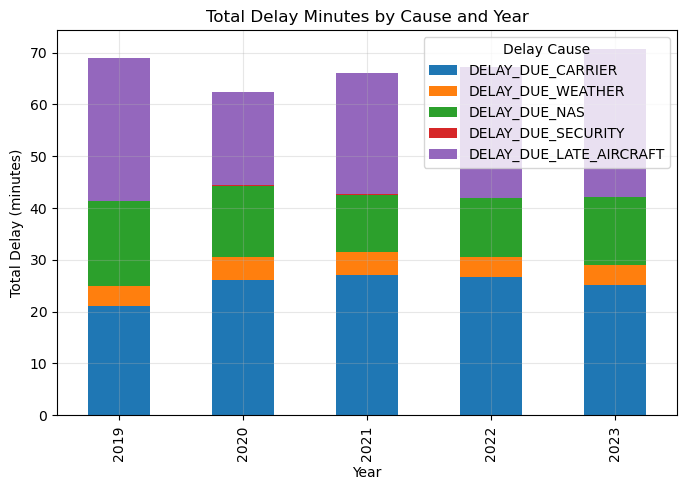

In [5]:
# Tự động tìm các cột có tên bắt đầu bằng 'DELAY_DUE_'
reason_cols = [col for col in df_flights.columns 
               if col.startswith("DELAY_DUE_")]

# tính avg các DELAY_DUE_ qua các năm
delay_reason_yearly = df_flights.groupby("YEAR")[reason_cols].mean().round(1).reset_index()

delay_reason_yearly.set_index("YEAR")[reason_cols].plot(
    kind="bar", stacked=True, figsize=(8,5)
)
plt.title("Total Delay Minutes by Cause and Year")
plt.ylabel("Total Delay (minutes)")
plt.xlabel("Year")
plt.legend(title="Delay Cause")
plt.grid(alpha=0.3)
plt.show()

In [6]:
delay_reason_yearly

,YEAR,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019,21.1,3.8,16.4,0.1,27.5
1,2020,26.2,4.3,13.7,0.2,18.0
2,2021,27.1,4.5,10.9,0.2,23.4
3,2022,26.7,3.8,11.4,0.1,25.3
4,2023,25.2,3.8,13.1,0.1,28.6


### Delay do “Late Aircraft” có mối liên hệ mạnh với ARR_DELAY tổng không?

In [7]:
late_aircraft_df = df_flights[["ARR_DELAY", "DELAY_DUE_LATE_AIRCRAFT"]].dropna()
late_aircraft_corr = late_aircraft_df.corr().iloc[0,1]
late_aircraft_corr

np.float64(0.5039827563355764)

Nhận xét:
- Late Aircraft Delay tăng → Arrival Delay cũng tăng
- corr ~ 0.503 -> trung bính - khá
- R-squared ≈ correlation^2 = 0.503^2 ≈ 0.253
- => Khoảng 25% biến động Arrival Delay đến từ Late Aircraft Delay.

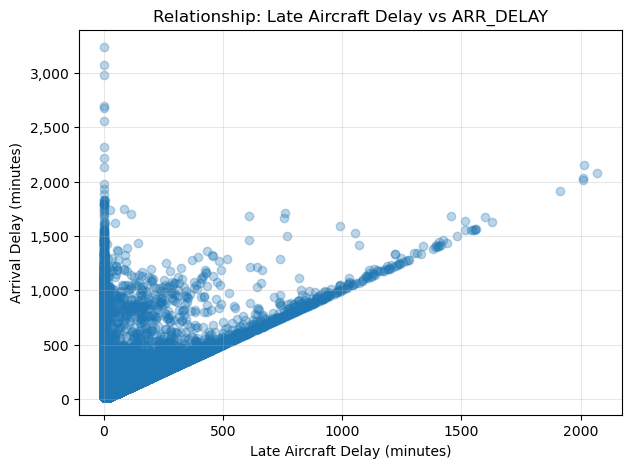

In [8]:
plt.figure(figsize=(7,5))
plt.scatter(late_aircraft_df["DELAY_DUE_LATE_AIRCRAFT"], 
            late_aircraft_df["ARR_DELAY"], alpha=0.3)
plt.xlabel("Late Aircraft Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.title("Relationship: Late Aircraft Delay vs ARR_DELAY")

# define a custom formatter function
def thousands_formatter(x, p):
    return format(int(x), ',')

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

plt.grid(alpha=0.3)
plt.show()

### Tỉ lệ delay do thời tiết khác nhau giữa các tháng như thế nào?

In [10]:
# tổng số chuyến bay delay 
delayed_df = df_flights[df_flights['ARR_DELAY'] > 15]
delayed_flights = delayed_df.groupby(["YEAR","MONTH"])['FL_DATE'].count().reset_index(name="Total_Flights")

# tổng số chuyến bay delay bởi weather
weather_df = df_flights[df_flights['DELAY_DUE_WEATHER'] > 0]
weather_flights = weather_df.groupby(["YEAR","MONTH"])['FL_DATE'].count().reset_index(name="Total_Flights_Weather")

dfs = [delayed_flights, weather_flights]
final_df = reduce(lambda l, r: l.merge(r, 
                                       on=["YEAR", "MONTH"], 
                                       how="left"), dfs).fillna(0)
final_df["Delay_Rate"] = (final_df["Total_Flights_Weather"] / final_df["Total_Flights"] * 100).round(2)
final_df

,YEAR,MONTH,Total_Flights,Total_Flights_Weather,Delay_Rate
0,2019,1,6902,488,7.07
1,2019,2,7818,553,7.07
2,2019,3,7007,298,4.25
3,2019,4,7039,414,5.88
4,2019,5,8379,610,7.28
5,2019,6,10129,726,7.17
6,2019,7,8977,704,7.84
7,2019,8,8670,552,6.37
8,2019,9,5512,269,4.88
9,2019,10,6830,295,4.32


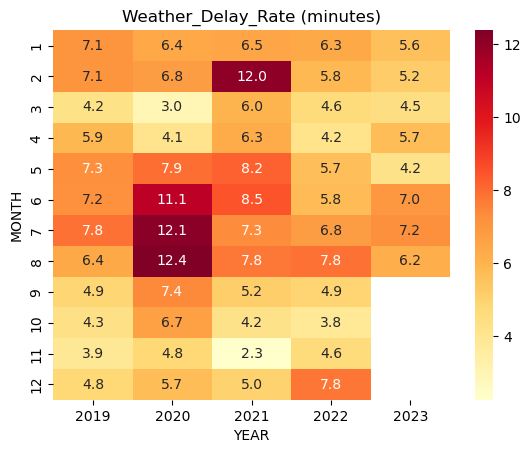

In [11]:
pivot = final_df.pivot(index="MONTH", columns="YEAR", values="Delay_Rate")

sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Weather_Delay_Rate (minutes)")
plt.show()

In [12]:
# Kiểm tra tương quan
# Python không fill NA, R có fill NA → kết quả lệch.
late_weather_df = delayed_df[["ARR_DELAY", "DELAY_DUE_WEATHER"]].dropna()
late_weather_corr = late_weather_df.corr().iloc[0,1]
late_weather_corr

np.float64(0.2872365248410074)

Nhận xét:
- DELAY_DUE_WEATHER tăng → Arrival Delay cũng tăng
- corr ~ 0.2872 -> thấp
- R-squared ≈ correlation^2 = 0.08248384 * 100 = 8.2%
- => Khoảng 8.2% biến động Arrival Delay đến từ Weather

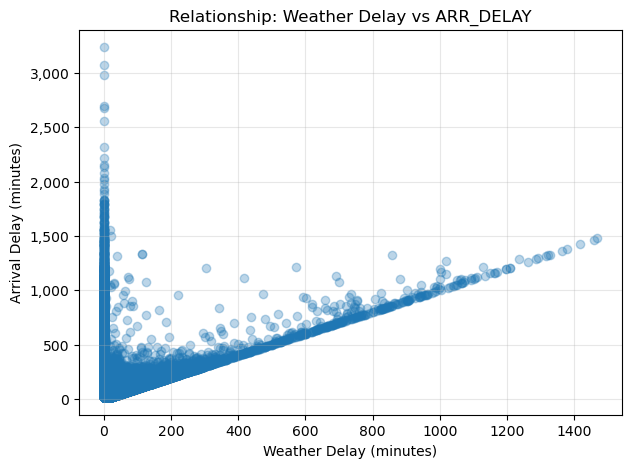

In [13]:
plt.figure(figsize=(7,5))
plt.scatter(late_weather_df["DELAY_DUE_WEATHER"], 
            late_weather_df["ARR_DELAY"], alpha=0.3)
plt.xlabel("Weather Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.title("Relationship: Weather Delay vs ARR_DELAY")

# define a custom formatter function
def thousands_formatter(x, p):
    return format(int(x), ',')

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

plt.grid(alpha=0.3)
plt.show()

### Có mối tương quan giữa DISTANCE và AIR_TIME không?

In [14]:
distance_air_df = df_flights[["DISTANCE", "AIR_TIME"]].dropna()
distance_air_corr = distance_air_df.corr().iloc[0, 1]
distance_air_corr

np.float64(0.9838620125436421)

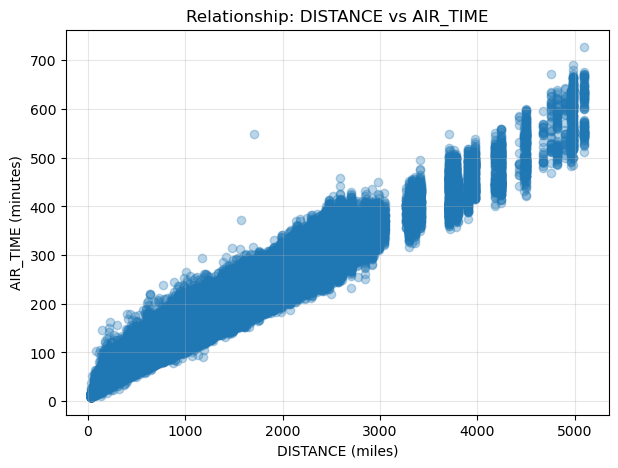

In [15]:
plt.figure(figsize=(7,5))
plt.scatter(distance_air_df["DISTANCE"], 
            distance_air_df["AIR_TIME"], alpha=0.3)
plt.xlabel("DISTANCE (miles)")
plt.ylabel("AIR_TIME (minutes)")
plt.title("Relationship: DISTANCE vs AIR_TIME")

# define a custom formatter function
def thousands_formatter(x, p):
    return format(int(x), ',')

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

plt.grid(alpha=0.3)
plt.show()

### Thời gian bay (AIR_TIME) dài hơn có làm tăng khả năng delay (ARR_DELAY) không?

In [16]:
airtime_arrdelay_df = df_flights[["AIR_TIME", "ARR_DELAY"]].dropna()
airtime_arrdelay_corr = airtime_arrdelay_df.corr().iloc[0, 1]
airtime_arrdelay_corr

np.float64(0.017230764990109858)

Nhận xét:

- AIR_TIME tăng → ARR_DELAY tăng rất ít, hầu như ko
- corr ~ 0.01723 -> rất thấp 
- R-squared ≈ correlation^2 = 0.002968 * 100 = 0.297%
=> Khoảng 0.297% biến động ARR_DELAY đến từ AIR_TIME

### Các chuyến đêm muộn hoặc sáng sớm có ít delay hơn không?

In [18]:
df_flights["HOUR"] = (df_flights["CRS_DEP_TIME"]//100).astype(int)

# Tạo nhóm thời gian: pd.cut()
# Không dùng 0–4 mà là -1–4 vì pd.cut() loại trừ giá trị đầu (left-open),
# Dùng -1 để chắc chắn rằng giá trị 0 (giờ 00:00) nằm trong khoảng đầu tiên.
# Dùng 24 để cho 23 vào khoảng cuối cùng.
# -1 -> 4: 00:00–04:59  |  # 4 → 7: 05:00–07:59  | # 7 → 16: 08:00–16:59 
# 16 → 21: 17:00–21:59  |  # 21 → 24: 22:00–23:59
df_flights["TIME_BIN"] = pd.cut(
    df_flights["HOUR"],
    bins=[-1, 4, 7, 16, 21, 24],
    labels=["Late Night", "Early Morning", "Daytime", "Evening", "Late Night"],
    right=True, 
    ordered=False # Nếu ordered=False, các labels phải unique
)

In [20]:
timebin_delay_flights = df_flights.groupby(["YEAR", "TIME_BIN"])["ARR_DELAY"].mean().reset_index(name="Delay_Rate").round(1)
timebin_delay_flights

,YEAR,TIME_BIN,Delay_Rate
0,2019,Daytime,4.4
1,2019,Early Morning,-1.6
2,2019,Evening,11.8
3,2019,Late Night,6.5
4,2020,Daytime,-5.3
5,2020,Early Morning,-6.0
6,2020,Evening,-3.8
7,2020,Late Night,-3.5
8,2021,Daytime,2.2
9,2021,Early Morning,-2.9


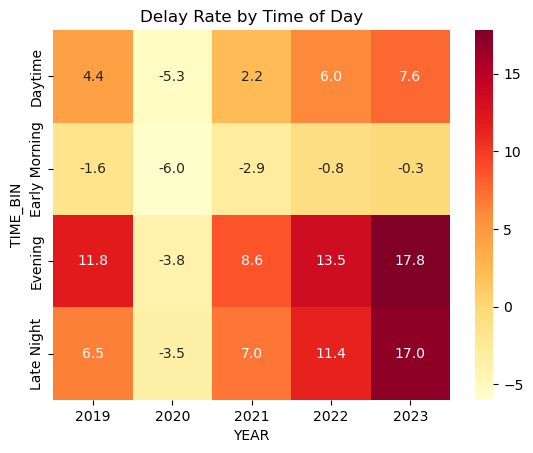

In [21]:
timebin_pivot = timebin_delay_flights.pivot(index="TIME_BIN", 
                                           columns="YEAR", 
                                           values="Delay_Rate")
sns.heatmap(timebin_pivot, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Delay Rate by Time of Day")
plt.show()

### Nguyên nhân hủy chuyến (A–D) nào phổ biến nhất?

In [22]:
cancell_code_yearly = df_flights.groupby(["YEAR", "CANCELLATION_CODE"])["FL_DATE"].count().reset_index(name = "Total_Flights")
cancell_code_yearly

,YEAR,CANCELLATION_CODE,Total_Flights
0,2019,A,2592
1,2019,B,4786
2,2019,C,1688
3,2019,D,1
4,2020,A,1327
5,2020,B,1427
6,2020,C,315
7,2020,D,16169
8,2021,A,2771
9,2021,B,3684


In [23]:
cancell_code = df_flights.groupby("CANCELLATION_CODE")["FL_DATE"].count().reset_index(name = "Total_Flights")
cancell_code

,CANCELLATION_CODE,Total_Flights
0,A,12825
1,B,19022
2,C,4367
3,D,16308


### Tháng nào có nhiều chuyến bị hủy nhất?

In [24]:
flights_cancel_monthly = df_flights.groupby("MONTH")["AIRLINE"].count().reset_index(name = "Total_Cancelled_Flights")
flights_cancel_monthly

,MONTH,Total_Cancelled_Flights
0,1,178613
1,2,165886
2,3,195852
3,4,169495
4,5,168074
5,6,174616
6,7,189800
7,8,191470
8,9,138057
9,10,144480


### Có mối quan hệ giữa weather delay và cancellation code = B không?
- Chỉ filter ra B → không kiểm tra được mối quan hệ.
- Để kiểm tra quan hệ, bạn phải giữ cả 2 nhóm: có delay và không, bị hủy B và không.
- Dùng: prop.table() + chisq.test() là rõ nhất.

#### Cách 1: So sánh nhóm hủy B và nhóm không hủy B

In [25]:
df_flights['is_cancelled_B'] = df_flights['CANCELLATION_CODE'] == 'B'
df_flights['has_weather_delay'] = df_flights['DELAY_DUE_WEATHER'] > 0

# bảng so sánh tỉ lệ theo nhóm
pd.crosstab(df_flights['has_weather_delay'], 
            df_flights['is_cancelled_B'], 
            normalize='index')

is_cancelled_B,False,True
has_weather_delay,,
False,0.990388,0.009612
True,1.000000,0.000000


In [27]:
df_flights['is_cancelled_B'].value_counts()

is_cancelled_B
False    1980978
True       19022
Name: count, dtype: int64

### Cách 2: Chi-square test (quan hệ giữa 2 biến phân loại)

In [29]:
# Tạo bảng 2 chiều
from scipy.stats import chi2_contingency
import statsmodels.api as sm

table = pd.crosstab(df_flights['has_weather_delay'], 
                    df_flights['is_cancelled_B'])

# Test
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 202.82846486850804
p-value: 5.042183622152878e-46
